In [1]:
import sys
sys.path.append('../build/')
%pylab inline
np.set_printoptions(precision=4, suppress=True)
from motor_estimation import MotorEstimationSolver
import pandas as pd
import linear_solver
import versor as vsr

Populating the interactive namespace from numpy and matplotlib


In [2]:
_epsilon = sqrt(finfo(float).eps)

In [3]:
def gradi(A, B, M):
    gi = np.zeros((6,1))
    MAM = A.spin(M)
    gi[0] = (MAM[0] * B[1] - MAM[1] * B[0]) * 2
    gi[1] = (MAM[0] * B[2] - MAM[2] * B[0]) * 2
    gi[2] = (MAM[1] * B[2] - MAM[2] * B[1]) * 2
    gi[3] = (-MAM[0] + B[0]) * 2
    gi[4] = (-MAM[1] + B[1]) * 2
    gi[5] = (-MAM[2] + B[2]) * 2
    return gi

In [4]:
def grad(points_a, points_b, mot):
    g = np.zeros((6,1))
    for A, B in zip(points_a, points_b):
        g += gradi(A,B,mot)
    return g

In [5]:
def Hessi(A, B, M):
    H = np.zeros((6,6))
    
    MAM = A.spin(M)
    
    a0,a1,a2,a3,a4 = np.array(MAM)
    b0,b1,b2,b3,b4 = np.array(B)
    
    H[0,0] = 4.0 * a1 * b1 + 4.0 * a0 * b0
    H[0,1] = 2.0 * a1 * b2 + 2.0 * a2 * b1
    H[0,2] = -2.0 * a0 * b2 - 2.0 * a2 * b0
    H[0,3] = -2.0 * b1 - 2.0 * a1
    H[0,4] = 2.0 * b0 + 2.0 * a0
    H[1,0] = H[0,1]
    H[2,0] = H[0,2]
    H[3,0] = H[0,3]
    H[4,0] = H[0,4]

    
    H[1,1] = 4.0 * a2 * b2 + 4.0 * a0 * b0
    H[1,2] = 2.0 * a0 * b1 + 2.0 * a1 * b0
    H[1,3] = -2.0 * b2 - 2.0 * a2
    H[1,5] = 2.0 * b0 + 2.0 * a0
    H[2,1] = H[1,2]
    H[3,1] = H[1,3]
    H[5,1] = H[1,5]
    
    H[2,2] = 4.0 * a2 * b2 + 4.0 * a1 * b1
    H[2,4] = -2.0 * b2 - 2.0 * a2
    H[2,5] = 2.0 * b1 + 2.0 * a1
    H[4,2] = H[2,4]
    H[5,2] = H[2,5]

    H[3,3] = 4.0
    H[4,4] = 4.0
    H[5,5] = 4.0
    
    return H

In [6]:
def Hess(points_a, points_b, mot):
    H = np.zeros((6,6))
    for A, B in zip(points_a, points_b):
        H += Hessi(A,B,mot)
    return H

In [7]:
def resi(A,B,M):
    return np.array(A.spin(M) - B)[:3].reshape(3,1)

In [8]:
def res(points_a, points_b, mot):
    r = np.zeros((3,1))
    for A, B in zip(points_a, points_b):
        r += np.array(A.spin(mot) - B)[:3].reshape(3,1)
    return r

In [9]:
def jaci2(a, mot):
    j = np.zeros((3,6))
    a = a.spin(mot)
    
    j[0,0] = -2 * a[1]
    j[1,0] = 2 * a[0]
    
    j[0,1] = -2 * a[2]
    j[2,1] =  2 * a[0]
    
    j[1,2] = -2 * a[2]
    j[2,2] = 2 * a[1]
    
    j[0,3] = 2
    j[1,4] = 2
    j[2,5] = 2
     
    return j

In [10]:
def jaci(a, mot):
    j = np.zeros((3,6))
    for i in range(6):
        dll = vsr.Dll(0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
        dll[i] = 1.0
        j[:,i] = -2.0 * np.array(dll.comm(a.spin(mot)))[:3]
    return j

In [11]:
def CayleySelig(B,M):
    Rp = vsr.Mot(1.0, B[0], B[1], B[2], 0.0, 0.0, 0.0, 0.0)
    Rn = vsr.Mot(1.0, -B[0], -B[1], -B[2], 0.0, 0.0, 0.0, 0.0)
    Rninv = Rn.inv()
    eps = vsr.Mot(0,0,0,0,0,0,0,-1)
    b = vsr.Mot(0.0, B[5], -B[4], B[3], 0.0, 0.0, 0.0, 0.0)
    return (Rp * Rninv + eps * Rninv * b * Rninv * 2) * M

def oexp(B,M):
    n = np.sqrt(1 + B[0] * B[0] + B[1] * B[1] + B[2] * B[2])
    s = B[0] * B[5] - B[1] * B[4] + B[2] * B[3]
    m = vsr.Mot(1.0, B[0], B[1], B[2], B[3], B[4], B[5], s) * (1.0 / n)
    return m * M

def CayleyLi(B,M):
    B_ = vsr.Mot(0.0, B[0], B[1], B[2], B[3], B[4], B[5], 0.0)
    BB = B_ * B_
    Rp = vsr.Mot(1.0, B[0], B[1], B[2], B[3], B[4], B[5], 0.0)
    R0 = vsr.Mot(1.0 - BB[0], 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    R4 = vsr.Mot(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, BB[7])
    Rn = R0 + R4
    Rden = R0 * R0 
    return (Rp * Rp * Rn * Rden.inv()) * M

def retr(B, M):
    B = vsr.Dll(*B)
    return (B * M + M).retract()

def expm(B, M):
    return vsr.Dll(*B).exp() * M


In [12]:
def update_n(points_a, points_b, mot, plus):
    H = Hess(points_a, points_b, mot)    
    g = grad(points_a, points_b, mot)

    B = -linear_solver.solve(H,g)   
        
    th = vsr.Biv(*B[:3]).norm()
    if th > pi:
        print('th')
#         B /= th
#         th = th - pi
#         B *= -th
    
    
    
    alpha = 0.01
    beta = 0.9
    eps = sqrt(finfo(float).eps)
    stp = 1.0
    len_p = norm(B)

    derphi = np.inner(g, B)[0][0]
    cost0 = costn(points_a, points_b, mot)
    
#     while costn(points_a, points_b, plus(stp * B, mot)) > cost0 + alpha * stp * derphi :
#         stp *= beta
#         if stp * len_p < eps:
#             break
    
    mot = plus(stp * B, mot)
    
    grad_norm = np.linalg.norm(g)
    return mot, costn(points_a, points_b, mot), grad_norm

In [13]:
def cost(points_a, points_b, mot):
    r = res(points_a, points_b, mot)
    return np.dot(r.T,r)[0][0] * 0.5

In [14]:
def costn(points_a, points_b, mot):
    return np.sum([(a.spin(mot) <= b) * -1.0 for a, b in zip(points_a, points_b)])

In [15]:
def update_sd(points_a, points_b, mot, plus=oexp):
    g = grad(points_a, points_b, mot)
    B = g * -1.0
    # line search
    alpha = 0.001
    beta = 0.9
    stp = 1.0
    eps = sqrt(finfo(float).eps)
    len_p = norm(B)
    
    cost0 = cost(points_a, points_b, mot)
    while cost(points_a, points_b, plus(stp * B, mot)) > cost0 + alpha * stp * np.inner(g, B)[0][0] :
        stp *= beta
        if stp * len_p < eps:
            break
    
    mot = plus(stp * B, mot)
    
    grad_norm = np.linalg.norm(g)
    return mot, cost(points_a, points_b, mot), grad_norm

In [16]:
def update_gn(points_a, points_b, mot, plus=oexp):
    J = np.array([jaci2(a, mot) for a in points_a]).reshape(-1,6)
    r = np.array([resi(a,b,mot) for a,b in zip(points_a, points_b)]).reshape(-1,1)    
    g = np.dot(J.T,r)
    H = np.dot(J.T,J)

    B = np.linalg.solve(H,g)   

    
    alpha = 0.0001
    beta = 0.5
    eps = sqrt(finfo(float).eps)
    stp = 1.0
    len_p = norm(B)

    derphi = np.inner(g, B)[0][0]
    cost0 = cost(points_a, points_b, mot)
    while cost(points_a, points_b, plus(stp * B, mot)) > cost0 + alpha * stp * derphi :
        stp *= beta
        if stp * len_p < eps:
            break
    
    
    mot = plus(stp * B, mot)
    grad_norm = np.linalg.norm(g)
    return mot, cost(points_a, points_b, mot), grad_norm

In [17]:
def create_motor(d_lims=(0, 1), th_lims=(0, np.pi)):
    translator = (vsr.Vec(*np.random.random(3)).unit()
                  * np.random.uniform(*d_lims)).trs()
    rotator = vsr.Rot(vsr.Biv(*np.random.uniform(-1, 1, 3)).unit()
                      * np.random.uniform(*th_lims) * -0.5)
    motor = translator * rotator
    return motor

In [42]:
def create_rotor(th_lims=(0, np.pi/2)):
    translator = vsr.Trs(1,0,0,0)
    rotator = vsr.Rot(vsr.Biv(*np.random.uniform(-1, 1, 3)).unit()
                      * np.random.uniform(*th_lims) * -0.5)
    motor = translator * rotator
    return motor

In [20]:
A = np.random.random((6,6))
b = np.random.random((6,1))

In [174]:
#%%timeit
#c= linear_solver.solve(A,b)

In [175]:
#%%timeit
#c = np.linalg.solve(A,b)

In [114]:
n_points=10

m0 = create_motor(th_lims=(0,np.pi/3))
points_a = [vsr.Vec(*np.random.normal(0.0, 0.8, 3)).null() for i in range(n_points)]
points_b = [point.spin(m0) for point in points_a]

mstart = create_motor()
mstart = vsr.Mot(1,0,0,0,0,0,0,0)

Mot: [ -1 5e-05 7.2e-06 9.7e-06 -1.2e-05 5.1e-06 3.2e-06 -7.8e-18 ]
Mot: [ -0.9 0.15 0.29 -0.28 0.019 0.011 0.015 0.0071 ]


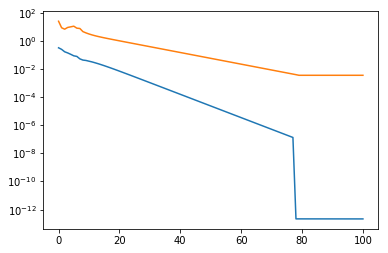

In [115]:
gnorms = []
costs = []
# plus = CayleySelig
plus = expm
m, c, gnorm = update_sd(points_a, points_b, mstart,plus)
costs.append(c)
gnorms.append(gnorm)
for i in range(100):
# while c > 1e-6:
    m, c, gnorm = update_sd(points_a, points_b, m, plus)
    costs.append(c)
    gnorms.append(gnorm)
semilogy(costs)
semilogy(gnorms)
print(m0.rev() * m)
print(m)

Mot: [ 1 0 -6.9e-18 0 2.8e-17 -3e-17 -2.7e-17 -2.6e-18 ]
Mot: [ 0.9 -0.15 -0.29 0.28 -0.019 -0.011 -0.015 -0.0071 ]


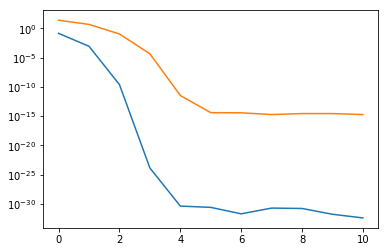

In [116]:
gnorms = []
costs = []
plus = oexp
m, c, gnorm = update_gn(points_a, points_b, mstart,plus)
costs.append(c)
gnorms.append(gnorm)
for i in range(10):
# while gnorm > 1e-6:
    m, c, gnorm = update_gn(points_a, points_b, m, plus)
    costs.append(c)
    gnorms.append(gnorm)
semilogy(costs)
semilogy(gnorms)
print(m0.rev() * m)
print(m)

In [125]:
costs = []
gnorms = []
# plus = expm
plus = oexp
plus = CayleyLi
m, c, gnorm = update_n(points_a, points_b, mstart, plus)
costs.append(c)
gnorms.append(gnorm)
while gnorm > 1e-3:
# for i in range(10):
    m, c, gnorm = update_n(points_a, points_b, m, plus)
    costs.append(c)
    gnorms.append(gnorm)
semilogy(gnorms)
semilogy(costs)
print(m0.rev() * m)
print(m)

th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th
th


KeyboardInterrupt: 

Mot: [ 1 -5.2e-13 4e-13 -1.4e-14 3.9e-12 -1.2e-12 -1.4e-12 -8.7e-19 ]
Mot: [ 0.9 -0.15 -0.29 0.28 -0.019 -0.011 -0.015 -0.0071 ]


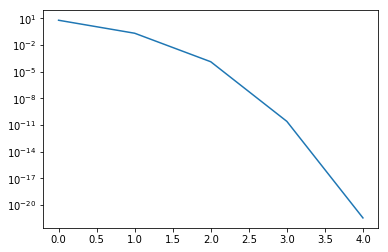

In [122]:
mes = MotorEstimationSolver(mstart)
for A, B in zip(points_a, points_b):
    mes.add_point_correspondences_residual_block(A,B)
# mes.set_parameterization('BIVECTOR_GENERATOR')
mes.set_parameterization('OUTER_EXPONENTIAL')
mes.linear_solver_type = 'DENSE_QR'
# mes.minimizer_type = 'LINE_SEARCH'
# mes.line_search_direction_type = 'STEEPEST_DESCENT'
# mes.line_search_direction_type = 'NONLINEAR_CONJUGATE_GRADIENT'
# mes.nonlinear_conjugate_gradient_type = 'HESTENES_STIEFEL'
# mes.line_search_type = 'ARMIJO'
# mes.max_num_iterations=20
(estimated_motor, summary, _) = mes.solve()
print(estimated_motor.rev() * m0)

print(estimated_motor)
# print(summary['full_report'])
semilogy(pd.DataFrame(summary['iterations'])['cost'])